In [2]:
# !pip install pgmpy

# Importing Dependencies

In [2]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
import networkx as nx


# Reading the Data

In [3]:
asset_vulnerability_df = pd.read_csv(r'C:\Users\swaroop.srisailam\Desktop\Swaroop\Bayesian Risk Assessment using Cybersecurity Data\dataset\asset_vulnerability.csv')
attack_vulnerability_df=pd.read_csv(r"C:\Users\swaroop.srisailam\Desktop\Swaroop\Bayesian Risk Assessment using Cybersecurity Data\dataset\attack_vulnerability.csv")
threat_actor_df=pd.read_csv(r"C:\Users\swaroop.srisailam\Desktop\Swaroop\Bayesian Risk Assessment using Cybersecurity Data\dataset\threat_actor_asset.csv")
prior_attack_df=pd.read_csv(r"C:\Users\swaroop.srisailam\Desktop\Swaroop\Bayesian Risk Assessment using Cybersecurity Data\dataset\prior_attack_success.csv")


In [4]:
print(asset_vulnerability_df.shape)
print(attack_vulnerability_df.shape)
print(threat_actor_df.shape)
print(prior_attack_df.shape)

(25, 4)
(25, 3)
(25, 3)
(25, 3)


# Defining Bayesian Network Structure

In [5]:
# model = BayesianNetwork([('Threat_Actor', 'Attack_Vector'),
#                          ('Attack_Vector', 'Vulnerability'),
#                          ('Vulnerability', 'Asset')])

In [6]:
assets = asset_vulnerability_df['Asset'].unique().tolist()

In [7]:
# Define the Bayesian Network structure
model = BayesianNetwork([('Threat_Actor', 'Attack_Vector'),
                         ('Attack_Vector', 'Vulnerability'),
                         ('Vulnerability', 'Asset')])


In [8]:
print(model)

BayesianNetwork with 4 nodes and 3 edges


# Defining Conditional Probability Distributions


# Step 4: Define Conditional Probability Distributions (CPDs)

# 4.1: CPD for Threat Actor based on prior attack success rates

In [24]:
threat_actor_counts = threat_actor_df['Threat_Actor'].value_counts()
total_count = threat_actor_counts.sum()
threat_actor_probs = threat_actor_counts / total_count
threat_actor_probs

Threat_Actor
External Hacker    0.52
Insider            0.48
Name: count, dtype: float64

In [26]:
cpd_threat_actor = TabularCPD(variable='Threat_Actor', 
                              variable_card=len(threat_actor_probs),  
                              values=[[threat_actor_probs.values[0]], 
                                      [threat_actor_probs.values[1]]])

In [27]:
print(cpd_threat_actor)

+-----------------+------+
| Threat_Actor(0) | 0.52 |
+-----------------+------+
| Threat_Actor(1) | 0.48 |
+-----------------+------+


## 4.2: CPD for Attack Vector given Threat Actor
## Calculate conditional probabilities using success rates

In [29]:
attack_vector_probs = prior_attack_df.pivot_table(index='Threat_Actor', columns='Attack_Vector', values='Success_Rate', aggfunc='mean').fillna(0)
attack_vector_probs_normalized = attack_vector_probs.div(attack_vector_probs.sum(axis=1), axis=0).values
cpd_attack_vector = TabularCPD(variable='Attack_Vector',
                               variable_card=attack_vector_probs_normalized.shape[1],
                               values=attack_vector_probs_normalized.T.tolist(), 
                               evidence=['Threat_Actor'],
                               evidence_card=[attack_vector_probs_normalized.shape[0]])

In [30]:
print(cpd_attack_vector)

+------------------+---------------------+---------------------+
| Threat_Actor     | Threat_Actor(0)     | Threat_Actor(1)     |
+------------------+---------------------+---------------------+
| Attack_Vector(0) | 0.22727272727272727 | 0.2190721649484536  |
+------------------+---------------------+---------------------+
| Attack_Vector(1) | 0.2681818181818182  | 0.2963917525773196  |
+------------------+---------------------+---------------------+
| Attack_Vector(2) | 0.23636363636363636 | 0.2577319587628866  |
+------------------+---------------------+---------------------+
| Attack_Vector(3) | 0.2681818181818182  | 0.22680412371134023 |
+------------------+---------------------+---------------------+


## 4.3: CPD for Vulnerability given Attack Vector
## Calculate conditional probabilities using success probabilities

In [18]:
attack_vulnerability_df['Vulnerability'].nunique()

13

In [31]:
vulnerability_pivot = attack_vulnerability_df.pivot_table(index='Attack_Vector', columns='Vulnerability', values='Success_Probability', aggfunc='mean').fillna(0)
vulnerability_probs_normalized = vulnerability_pivot.div(vulnerability_pivot.sum(axis=1), axis=0).values

In [32]:
vulnerability_pivot

Vulnerability,CVE-2023-09876,CVE-2023-12345,CVE-2023-23456,CVE-2023-34567,CVE-2023-45678,CVE-2023-54321,CVE-2023-54322,CVE-2023-67890,CVE-2023-67891,CVE-2023-76543,CVE-2023-87653,CVE-2023-87654,CVE-2023-98765
Attack_Vector,,,,,,,,,,,,,
Phishing,0.55,0.000,0.0,0.55,0.00,0.6,0.00,0.00,0.00,0.50,0.5,0.0,0.00
RCE,0.00,0.000,0.0,0.60,0.00,0.7,0.75,0.00,0.00,0.65,0.0,0.6,0.65
Remote Code Execution,0.00,0.800,0.0,0.00,0.00,0.0,0.00,0.00,0.65,0.00,0.0,0.0,0.00
SQL Injection,0.80,0.775,0.7,0.00,0.85,0.0,0.85,0.85,0.75,0.70,0.0,0.8,0.75


In [21]:
vulnerability_probs_normalized.shape[1]

13

In [22]:
vulnerability_probs_normalized.T.tolist()

[[0.20370370370370372, 0.0, 0.0, 0.10223642172523963],
 [0.0, 0.0, 0.5517241379310345, 0.09904153354632587],
 [0.0, 0.0, 0.0, 0.08945686900958466],
 [0.20370370370370372, 0.1518987341772152, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.10862619808306709],
 [0.2222222222222222, 0.17721518987341772, 0.0, 0.0],
 [0.0, 0.189873417721519, 0.0, 0.10862619808306709],
 [0.0, 0.0, 0.0, 0.10862619808306709],
 [0.0, 0.0, 0.44827586206896547, 0.09584664536741214],
 [0.18518518518518517, 0.16455696202531647, 0.0, 0.08945686900958466],
 [0.18518518518518517, 0.0, 0.0, 0.0],
 [0.0, 0.1518987341772152, 0.0, 0.10223642172523963],
 [0.0, 0.16455696202531647, 0.0, 0.09584664536741214]]

In [33]:
cpd_vulnerability = TabularCPD(variable='Vulnerability', 
                               variable_card=vulnerability_probs_normalized.shape[1], 
                               values=vulnerability_probs_normalized.T.tolist(), 
                               evidence=['Attack_Vector'],
                               evidence_card=[vulnerability_probs_normalized.shape[0]])

In [34]:
print(cpd_vulnerability)

+-------------------+-----+---------------------+
| Attack_Vector     | ... | Attack_Vector(3)    |
+-------------------+-----+---------------------+
| Vulnerability(0)  | ... | 0.10223642172523963 |
+-------------------+-----+---------------------+
| Vulnerability(1)  | ... | 0.09904153354632587 |
+-------------------+-----+---------------------+
| Vulnerability(2)  | ... | 0.08945686900958466 |
+-------------------+-----+---------------------+
| Vulnerability(3)  | ... | 0.0                 |
+-------------------+-----+---------------------+
| Vulnerability(4)  | ... | 0.10862619808306709 |
+-------------------+-----+---------------------+
| Vulnerability(5)  | ... | 0.0                 |
+-------------------+-----+---------------------+
| Vulnerability(6)  | ... | 0.10862619808306709 |
+-------------------+-----+---------------------+
| Vulnerability(7)  | ... | 0.10862619808306709 |
+-------------------+-----+---------------------+
| Vulnerability(8)  | ... | 0.09584664536741214 |


## 4.4: CPD for Asset given Vulnerability
## Calculate conditional probabilities using exploit probabilities

In [35]:
asset_vulnerability_df['Asset'].nunique()

25

In [37]:
asset_pivot = asset_vulnerability_df.pivot_table(index='Vulnerability', columns='Asset', values='Exploit_Probability', aggfunc='mean').fillna(0)
asset_probs_normalized = asset_pivot.div(asset_pivot.sum(axis=1), axis=0).values

In [38]:
cpd_asset = TabularCPD(variable='Asset', 
                       variable_card=asset_probs_normalized.shape[1], 
                       values=asset_probs_normalized.T.tolist(), 
                       evidence=['Vulnerability'],
                       evidence_card=[asset_probs_normalized.shape[0]])

In [39]:
print(cpd_asset)

+---------------+------------------+-----+---------------------+
| Vulnerability | Vulnerability(0) | ... | Vulnerability(12)   |
+---------------+------------------+-----+---------------------+
| Asset(0)      | 0.0              | ... | 0.0                 |
+---------------+------------------+-----+---------------------+
| Asset(1)      | 0.0              | ... | 0.3412322274881517  |
+---------------+------------------+-----+---------------------+
| Asset(2)      | 0.0              | ... | 0.0                 |
+---------------+------------------+-----+---------------------+
| Asset(3)      | 0.0              | ... | 0.0                 |
+---------------+------------------+-----+---------------------+
| Asset(4)      | 0.0              | ... | 0.33649289099526064 |
+---------------+------------------+-----+---------------------+
| Asset(5)      | 0.0              | ... | 0.0                 |
+---------------+------------------+-----+---------------------+
| Asset(6)      | 0.0    

## Add CPDs to the model

In [40]:
model.add_cpds(cpd_threat_actor, cpd_attack_vector, cpd_vulnerability, cpd_asset)

In [41]:
# Verify model correctness
assert model.check_model()

In [42]:
# Perform inference
inference = VariableElimination(model)

In [43]:
# Query posterior probabilities of assets given evidence
posterior_assets = inference.map_query(variables=['Asset'], evidence={'Threat_Actor': 0, 'Attack_Vector': 0})



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
# Ranking assets based on risk
ranked_assets = sorted(posterior_assets.items(), key=lambda x: x[1], reverse=True)



In [45]:
ranked_assets

[('Asset', 6)]

StopIteration: 

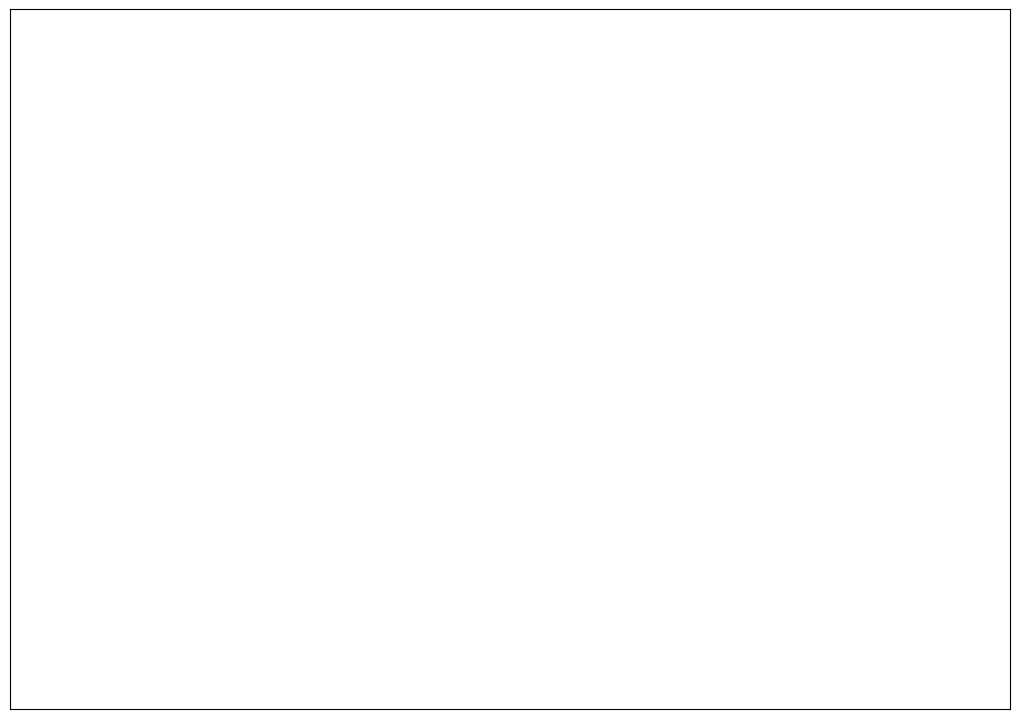

In [46]:
# Visualize the Bayesian Network
plt.figure(figsize=(10,7))
nx.draw(model, with_labels=True, node_size=3000, font_size=12, node_color='skyblue', font_weight='bold')
plt.show()

In [38]:
print("Nodes: ", model.nodes())
print("Edges: ", model.edges())


Nodes:  ['Threat_Actor', 'Attack_Vector', 'Vulnerability', 'Asset']
Edges:  [('Threat_Actor', 'Attack_Vector'), ('Attack_Vector', 'Vulnerability'), ('Vulnerability', 'Asset')]


In [45]:
pos = nx.spring_layout(model, seed=42)  # You can also try nx.shell_layout(model)

# Visualize the Bayesian Network
plt.figure(figsize=(10,7))


<Figure size 1000x700 with 0 Axes>

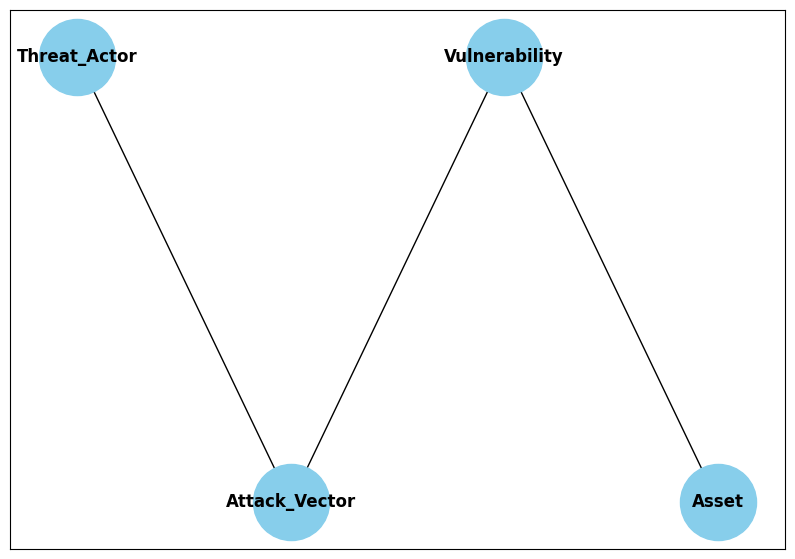

In [48]:
pos = {'Threat_Actor': [0, 1], 'Attack_Vector': [1, 0], 'Vulnerability': [2, 1], 'Asset': [3, 0]}
  # Ensure positions are valid and consistent

# Plot the network
plt.figure(figsize=(10,7))

# Draw nodes and edges without arrows for now
nx.draw_networkx_nodes(model, pos, node_size=3000, node_color='skyblue')
nx.draw_networkx_edges(model, pos, arrows=False)  # Disable arrows for edge rendering
nx.draw_networkx_labels(model, pos, font_size=12, font_weight='bold')

plt.show()

In [41]:
pos

{'Threat_Actor': array([nan, nan]),
 'Attack_Vector': array([nan, nan]),
 'Vulnerability': array([nan, nan]),
 'Asset': array([nan, nan])}

StopIteration: 

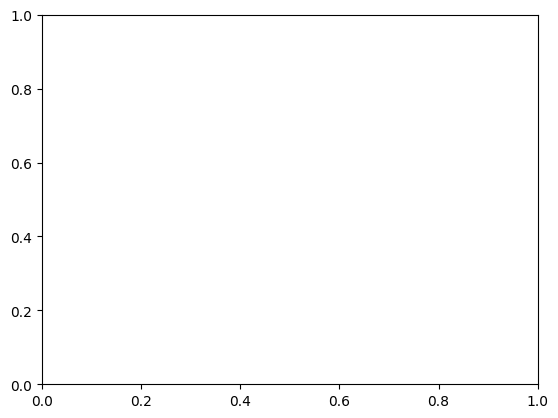

In [40]:
nx.draw_networkx_edges(model, pos)

In [35]:
# Print ranked assets
for asset, risk in ranked_assets:
    print(f"Asset: {asset}, Risk: {risk}")

Asset: Asset, Risk: 6


In [36]:
ranked_assets

[('Asset', 6)]